# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### embedを得るためのnote

In [1]:
! nvidia-smi

Sun Jun  5 14:49:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=500
    epochs=4
    encoder_lr=1.5e-5
    decoder_lr=15e-5 # decoder_lrを10倍してみる
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=32#16
    fc_dropout=0.0
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=10
    trn_fold=[0, 1, 2, 3]
    train=True
    newtrain = False

    name = "exp019" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c93988bbe5bc3c6d2f5ea17b8b4df8fdbccdb203bed3803fc774ab9a5133ee5b
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 11.5 MB/s 
     |████████████████████████████████| 6.6 MB 31.8 MB/s 
     |████████████████████████████████| 596 kB 10.3 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 30.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
# print(f"train.shape: {train.shape}")
# print(f"test.shape: {test.shape}")
# print(f"submission.shape: {submission.shape}")
# display(train.head())
# display(test.head())
# display(submission.head())

In [11]:
# ====================================================
# CPC Data
# ====================================================
# def get_cpc_texts():
#     contexts = []
#     pattern = '[A-Z]\d+'
#     if COLAB:
#         cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
#     else:
#         cpcpath = '../input/cpc-data/CPCSchemeXML202105'
#     for file_name in os.listdir(cpcpath):
#         result = re.findall(pattern, file_name)
#         if result:
#             contexts.append(result)
#     contexts = sorted(set(sum(contexts, [])))
#     results = {}
#     for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
#         if COLAB:
#             cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
#         else:
#             cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
#         with open(cpcpath) as f:
#             s = f.read()
#         pattern = f'{cpc}\t\t.+'
#         result = re.findall(pattern, s)
#         cpc_result = result[0].lstrip(pattern)
#         for context in [c for c in contexts if c[0] == cpc]:
#             pattern = f'{context}\t\t.+'
#             result = re.findall(pattern, s)
#             results[context] = cpc_result + ". " + result[0].lstrip(pattern)
#     return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
# train['context_text'] = train['context'].map(cpc_texts)
# test['context_text'] = test['context'].map(cpc_texts)
# display(train.head())
# display(test.head())

In [12]:
path = os.path.join(INPUT_DIR, 'titles.csv')
title = pd.read_csv(path)
def get_first_slice(text):
    texts = text.split(';')
    return texts[0]

def add_cpc(test):
    test = test.merge(title, left_on='context', right_on='code')

    detail_dict = dict(zip(title['code'], title['title']))
    test['section'] = test['context'].map(lambda x: str(x)[0])

    test['context_text'] = test['context'].map(lambda x: detail_dict[x])
    test['section_text'] = test['section'].map(lambda x: detail_dict[x])

    test['context_text'] = test['context_text'].map(get_first_slice)
    test['section_text'] = test['section_text'].map(get_first_slice)
    test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]' + test['section_text'] + '.' + test['context_text']
    return test

train = add_cpc(train)
test = add_cpc(test)

In [13]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
# display(train.head())
# display(test.head())

# EDA

In [14]:
# train['score'].hist()

In [15]:
# display(train['context'].apply(lambda x: x[0]).value_counts())

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    3648
1    3648
2    3648
3    3647
4    3647
5    3647
6    3647
7    3647
8    3647
9    3647
dtype: int64

In [17]:
# # ====================================================
# # CV split
# # ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'], train['anchor'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
# tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
# for text in tk0:
#     length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#     lengths.append(length)
# lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target', 'context_text', 'section_text']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 5 # CLS + SEP + SEP + SEP + .
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 70


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [24]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        in_features = self.config.hidden_size
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
#         print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

In [25]:
class Pearson_Loss(nn.Module):
    def __init__(self):
        super(Pearson_Loss, self).__init__()

    def forward(self, label, preds):
        preds_mean = torch.mean(preds)
        label_mean = torch.mean(label)

        num = torch.sum(torch.mul((preds-preds_mean),(label-label_mean)))

        pred_std = torch.sum(torch.square((preds-preds_mean)))
        label_std = torch.sum(torch.square((label-label_mean)))
        den = torch.sqrt(pred_std * label_std)
        loss = 1-torch.divide(num, den)

        return loss

# Helpler functions

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = 0
        for criterion in criterions:
            loss += criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterions, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = 0
        for criterion in criterions:
            loss += criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [27]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=600)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())

        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
#     predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values

    # newtrain ============================================
    if CFG.newtrain:
        path = os.path.join(INPUT_DIR, 'newtrain.csv')
        df = pd.read_csv(path)
        r = [0.95, 0.97, 0.7, 0.60, 0.98]
        m = ['0', '1', '2', '3', '4']
        new_df = []
        for i, j in zip(m, r):
            idx = df[i] > j
            df.loc[idx, 'score'] = int(i) * 0.25
            new_df.append(df[idx])
        new_train = pd.concat(new_df)
        train_folds = pd.concat([train_folds[['text', 'score']], new_train[['text', 'score']]])
    # ======================================================
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    model.config.update(
        {
            "attention_probs_dropout_prob" : 0.0,
            "hidden_dropout_prob": 0.0
        }
    )
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = [nn.BCEWithLogitsLoss(reduction="mean"), nn.MSELoss(reduction='mean'), Pearson_Loss()]
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1025] Elapsed 0m 2s (remain 34m 37s) Loss: 1.7471(1.7471) Grad: nan  LR: 0.00000003  
Epoch: [1][100/1025] Elapsed 1m 42s (remain 15m 39s) Loss: 1.1797(1.5920) Grad: 89236.2188  LR: 0.00000303  
Epoch: [1][200/1025] Elapsed 3m 23s (remain 13m 54s) Loss: 1.1113(1.3948) Grad: 63554.4883  LR: 0.00000603  
Epoch: [1][300/1025] Elapsed 5m 4s (remain 12m 11s) Loss: 1.0010(1.2754) Grad: 24777.0508  LR: 0.00000903  
Epoch: [1][400/1025] Elapsed 6m 44s (remain 10m 30s) Loss: 1.0762(1.2044) Grad: 22636.7227  LR: 0.00001203  
Epoch: [1][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 1.1641(1.1539) Grad: 32305.4238  LR: 0.00001500  
Epoch: [1][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 1.0918(1.1169) Grad: 24203.8438  LR: 0.00001497  
Epoch: [1][700/1025] Elapsed 11m 45s (remain 5m 26s) Loss: 0.8608(1.0898) Grad: 17164.9922  LR: 0.00001489  
Epoch: [1][800/1025] Elapsed 13m 25s (remain 3m 45s) Loss: 0.7866(1.0698) Grad: 12653.4336  LR: 0.00001474  
Epoch: [1][900/1025] Elapsed 15m 

Epoch 1 - Score: 0.8466


Epoch: [2][0/1025] Elapsed 0m 1s (remain 21m 40s) Loss: 0.9023(0.9023) Grad: nan  LR: 0.00001422  
Epoch: [2][100/1025] Elapsed 1m 41s (remain 15m 31s) Loss: 0.9375(0.8419) Grad: 72981.8203  LR: 0.00001391  
Epoch: [2][200/1025] Elapsed 3m 21s (remain 13m 47s) Loss: 0.8701(0.8447) Grad: 24008.4551  LR: 0.00001355  
Epoch: [2][300/1025] Elapsed 5m 1s (remain 12m 6s) Loss: 0.8110(0.8410) Grad: 197418.6406  LR: 0.00001314  
Epoch: [2][400/1025] Elapsed 6m 42s (remain 10m 25s) Loss: 0.9302(0.8412) Grad: 46130.3984  LR: 0.00001269  
Epoch: [2][500/1025] Elapsed 8m 22s (remain 8m 45s) Loss: 0.8389(0.8437) Grad: 309756.8125  LR: 0.00001219  
Epoch: [2][600/1025] Elapsed 10m 2s (remain 7m 4s) Loss: 0.7637(0.8442) Grad: 20179.5391  LR: 0.00001167  
Epoch: [2][700/1025] Elapsed 11m 42s (remain 5m 24s) Loss: 0.7856(0.8412) Grad: 31668.4570  LR: 0.00001111  
Epoch: [2][800/1025] Elapsed 13m 22s (remain 3m 44s) Loss: 0.7949(0.8390) Grad: 23372.2812  LR: 0.00001052  
Epoch: [2][900/1025] Elapsed 15m

Epoch 2 - Score: 0.8578


Epoch: [3][0/1025] Elapsed 0m 1s (remain 21m 52s) Loss: 0.7720(0.7720) Grad: nan  LR: 0.00000913  
Epoch: [3][100/1025] Elapsed 1m 42s (remain 15m 36s) Loss: 0.7964(0.7993) Grad: 81860.6172  LR: 0.00000848  
Epoch: [3][200/1025] Elapsed 3m 22s (remain 13m 51s) Loss: 0.7349(0.7990) Grad: 32953.4258  LR: 0.00000783  
Epoch: [3][300/1025] Elapsed 5m 3s (remain 12m 9s) Loss: 0.8379(0.7984) Grad: 65264.6641  LR: 0.00000718  
Epoch: [3][400/1025] Elapsed 6m 43s (remain 10m 27s) Loss: 0.7651(0.7963) Grad: 16357.9590  LR: 0.00000653  
Epoch: [3][500/1025] Elapsed 8m 23s (remain 8m 46s) Loss: 0.7778(0.7967) Grad: 16864.6211  LR: 0.00000588  
Epoch: [3][600/1025] Elapsed 10m 3s (remain 7m 6s) Loss: 0.7046(0.7954) Grad: 13171.2842  LR: 0.00000525  
Epoch: [3][700/1025] Elapsed 11m 44s (remain 5m 25s) Loss: 0.7622(0.7943) Grad: 23650.5645  LR: 0.00000464  
Epoch: [3][800/1025] Elapsed 13m 24s (remain 3m 44s) Loss: 0.8184(0.7938) Grad: 35082.4414  LR: 0.00000404  
Epoch: [3][900/1025] Elapsed 15m 4

Epoch 3 - Score: 0.8705


Epoch: [4][0/1025] Elapsed 0m 1s (remain 22m 33s) Loss: 0.7969(0.7969) Grad: nan  LR: 0.00000281  
Epoch: [4][100/1025] Elapsed 1m 42s (remain 15m 35s) Loss: 0.7661(0.7814) Grad: 76760.4062  LR: 0.00000232  
Epoch: [4][200/1025] Elapsed 3m 22s (remain 13m 51s) Loss: 0.7124(0.7739) Grad: 47402.2266  LR: 0.00000187  
Epoch: [4][300/1025] Elapsed 5m 3s (remain 12m 9s) Loss: 0.6895(0.7725) Grad: 72968.2031  LR: 0.00000146  
Epoch: [4][400/1025] Elapsed 6m 43s (remain 10m 27s) Loss: 0.7520(0.7722) Grad: 70498.8047  LR: 0.00000109  
Epoch: [4][500/1025] Elapsed 8m 23s (remain 8m 46s) Loss: 0.7031(0.7698) Grad: 40277.6055  LR: 0.00000078  
Epoch: [4][600/1025] Elapsed 10m 3s (remain 7m 5s) Loss: 0.7627(0.7687) Grad: 100688.3750  LR: 0.00000051  
Epoch: [4][700/1025] Elapsed 11m 44s (remain 5m 25s) Loss: 0.7500(0.7682) Grad: 58423.9492  LR: 0.00000030  
Epoch: [4][800/1025] Elapsed 13m 24s (remain 3m 44s) Loss: 0.6973(0.7688) Grad: 60393.0312  LR: 0.00000015  
Epoch: [4][900/1025] Elapsed 15m 

Epoch 4 - Score: 0.8711
========== fold: 0 result ==========
Score: 0.8711
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1025] Elapsed 0m 3s (remain 54m 6s) Loss: 1.8711(1.8711) Grad: nan  LR: 0.00000003  
Epoch: [1][100/1025] Elapsed 1m 43s (remain 15m 47s) Loss: 1.5820(1.7295) Grad: 106786.0156  LR: 0.00000303  
Epoch: [1][200/1025] Elapsed 3m 23s (remain 13m 55s) Loss: 0.9746(1.4559) Grad: 54080.9453  LR: 0.00000603  
Epoch: [1][300/1025] Elapsed 5m 3s (remain 12m 11s) Loss: 0.9668(1.3134) Grad: 22980.8594  LR: 0.00000903  
Epoch: [1][400/1025] Elapsed 6m 44s (remain 10m 28s) Loss: 0.8579(1.2319) Grad: 10460.3438  LR: 0.00001203  
Epoch: [1][500/1025] Elapsed 8m 24s (remain 8m 47s) Loss: 1.0723(1.1777) Grad: 14039.6426  LR: 0.00001500  
Epoch: [1][600/1025] Elapsed 10m 4s (remain 7m 6s) Loss: 0.9639(1.1381) Grad: 11142.6914  LR: 0.00001497  
Epoch: [1][700/1025] Elapsed 11m 44s (remain 5m 25s) Loss: 0.7681(1.1101) Grad: 6646.0371  LR: 0.00001489  
Epoch: [1][800/1025] Elapsed 13m 25s (remain 3m 45s) Loss: 1.0586(1.0862) Grad: 10540.0596  LR: 0.00001474  
Epoch: [1][900/1025] Elapsed 15m 5

Epoch 1 - Score: 0.8396


Epoch: [2][0/1025] Elapsed 0m 1s (remain 22m 25s) Loss: 0.7280(0.7280) Grad: nan  LR: 0.00001422  
Epoch: [2][100/1025] Elapsed 1m 42s (remain 15m 37s) Loss: 0.8413(0.8664) Grad: 90812.3984  LR: 0.00001391  
Epoch: [2][200/1025] Elapsed 3m 22s (remain 13m 51s) Loss: 0.8730(0.8545) Grad: 129167.0312  LR: 0.00001355  
Epoch: [2][300/1025] Elapsed 5m 3s (remain 12m 9s) Loss: 0.9282(0.8479) Grad: 130352.5469  LR: 0.00001314  
Epoch: [2][400/1025] Elapsed 6m 43s (remain 10m 28s) Loss: 0.7617(0.8460) Grad: 61473.9727  LR: 0.00001269  
Epoch: [2][500/1025] Elapsed 8m 24s (remain 8m 47s) Loss: 0.7417(0.8410) Grad: 64155.0664  LR: 0.00001219  
Epoch: [2][600/1025] Elapsed 10m 4s (remain 7m 6s) Loss: 0.7593(0.8368) Grad: 59774.8672  LR: 0.00001167  
Epoch: [2][700/1025] Elapsed 11m 45s (remain 5m 25s) Loss: 0.7300(0.8360) Grad: 57445.5234  LR: 0.00001111  
Epoch: [2][800/1025] Elapsed 13m 25s (remain 3m 45s) Loss: 0.7979(0.8344) Grad: 84825.7578  LR: 0.00001052  
Epoch: [2][900/1025] Elapsed 15m

Epoch 2 - Score: 0.8582


Epoch: [3][0/1025] Elapsed 0m 1s (remain 23m 6s) Loss: 0.7544(0.7544) Grad: nan  LR: 0.00000913  
Epoch: [3][100/1025] Elapsed 1m 42s (remain 15m 35s) Loss: 0.7842(0.8117) Grad: 76645.1016  LR: 0.00000848  
Epoch: [3][200/1025] Elapsed 3m 22s (remain 13m 52s) Loss: 0.8486(0.8128) Grad: 84014.3438  LR: 0.00000783  
Epoch: [3][300/1025] Elapsed 5m 3s (remain 12m 9s) Loss: 0.7466(0.8117) Grad: 83059.7656  LR: 0.00000718  
Epoch: [3][400/1025] Elapsed 6m 43s (remain 10m 28s) Loss: 0.8584(0.8098) Grad: 102960.3594  LR: 0.00000653  
Epoch: [3][500/1025] Elapsed 8m 24s (remain 8m 47s) Loss: 0.7876(0.8103) Grad: 63566.7539  LR: 0.00000588  
Epoch: [3][600/1025] Elapsed 10m 4s (remain 7m 6s) Loss: 0.8335(0.8095) Grad: 200742.5000  LR: 0.00000525  
Epoch: [3][700/1025] Elapsed 11m 45s (remain 5m 25s) Loss: 0.7881(0.8089) Grad: 113522.0078  LR: 0.00000464  
Epoch: [3][800/1025] Elapsed 13m 25s (remain 3m 45s) Loss: 0.7876(0.8095) Grad: 139130.8594  LR: 0.00000404  
Epoch: [3][900/1025] Elapsed 15

Epoch 3 - Score: 0.8619


Epoch: [4][0/1025] Elapsed 0m 1s (remain 22m 33s) Loss: 0.7266(0.7266) Grad: nan  LR: 0.00000281  
Epoch: [4][100/1025] Elapsed 1m 42s (remain 15m 37s) Loss: 0.7803(0.7996) Grad: 112939.8984  LR: 0.00000232  
Epoch: [4][200/1025] Elapsed 3m 22s (remain 13m 51s) Loss: 0.6963(0.8006) Grad: 40083.8789  LR: 0.00000187  
Epoch: [4][300/1025] Elapsed 5m 3s (remain 12m 10s) Loss: 0.8032(0.7994) Grad: 86366.0781  LR: 0.00000146  
Epoch: [4][400/1025] Elapsed 6m 44s (remain 10m 28s) Loss: 0.7944(0.7994) Grad: 61073.1211  LR: 0.00000109  
Epoch: [4][500/1025] Elapsed 8m 24s (remain 8m 47s) Loss: 0.8193(0.8001) Grad: 90131.7891  LR: 0.00000078  
Epoch: [4][600/1025] Elapsed 10m 5s (remain 7m 6s) Loss: 0.8271(0.7992) Grad: 83382.3359  LR: 0.00000051  
Epoch: [4][700/1025] Elapsed 11m 45s (remain 5m 26s) Loss: 0.8789(0.7988) Grad: 144162.8438  LR: 0.00000030  
Epoch: [4][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.9414(0.7999) Grad: 139780.7656  LR: 0.00000015  
Epoch: [4][900/1025] Elapsed 1

Epoch 4 - Score: 0.8627
========== fold: 1 result ==========
Score: 0.8627
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1025] Elapsed 0m 2s (remain 49m 17s) Loss: 2.2461(2.2461) Grad: nan  LR: 0.00000003  
Epoch: [1][100/1025] Elapsed 1m 43s (remain 15m 47s) Loss: 1.2549(1.6082) Grad: 21878.0488  LR: 0.00000303  
Epoch: [1][200/1025] Elapsed 3m 24s (remain 13m 56s) Loss: 1.0957(1.3512) Grad: 17350.7402  LR: 0.00000603  
Epoch: [1][300/1025] Elapsed 5m 4s (remain 12m 12s) Loss: 0.8335(1.2389) Grad: 8387.5293  LR: 0.00000903  
Epoch: [1][400/1025] Elapsed 6m 45s (remain 10m 30s) Loss: 1.0234(1.1726) Grad: 16406.2207  LR: 0.00001203  
Epoch: [1][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 0.8833(1.1233) Grad: 10794.3936  LR: 0.00001500  
Epoch: [1][600/1025] Elapsed 10m 6s (remain 7m 7s) Loss: 1.0391(1.0935) Grad: 12014.3291  LR: 0.00001497  
Epoch: [1][700/1025] Elapsed 11m 46s (remain 5m 26s) Loss: 0.8472(1.0695) Grad: 6795.7490  LR: 0.00001489  
Epoch: [1][800/1025] Elapsed 13m 27s (remain 3m 45s) Loss: 0.8398(1.0518) Grad: 7215.2500  LR: 0.00001474  
Epoch: [1][900/1025] Elapsed 15m 7s 

Epoch 1 - Score: 0.8345


Epoch: [2][0/1025] Elapsed 0m 1s (remain 23m 2s) Loss: 0.8672(0.8672) Grad: nan  LR: 0.00001422  
Epoch: [2][100/1025] Elapsed 1m 43s (remain 15m 42s) Loss: 0.8003(0.8496) Grad: 141336.4375  LR: 0.00001391  
Epoch: [2][200/1025] Elapsed 3m 23s (remain 13m 54s) Loss: 0.8066(0.8451) Grad: 82424.3203  LR: 0.00001355  
Epoch: [2][300/1025] Elapsed 5m 4s (remain 12m 11s) Loss: 1.0156(0.8459) Grad: 160569.9531  LR: 0.00001314  
Epoch: [2][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 0.8159(0.8434) Grad: 46629.4180  LR: 0.00001269  
Epoch: [2][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 0.7788(0.8392) Grad: 49510.5117  LR: 0.00001219  
Epoch: [2][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.7437(0.8378) Grad: 71466.1250  LR: 0.00001167  
Epoch: [2][700/1025] Elapsed 11m 46s (remain 5m 26s) Loss: 0.8091(0.8363) Grad: 37995.5352  LR: 0.00001111  
Epoch: [2][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.8154(0.8371) Grad: 49694.4766  LR: 0.00001052  
Epoch: [2][900/1025] Elapsed 15m

Epoch 2 - Score: 0.8489


Epoch: [3][0/1025] Elapsed 0m 1s (remain 22m 57s) Loss: 0.8516(0.8516) Grad: nan  LR: 0.00000913  
Epoch: [3][100/1025] Elapsed 1m 42s (remain 15m 37s) Loss: 0.7344(0.8172) Grad: 62778.0820  LR: 0.00000848  
Epoch: [3][200/1025] Elapsed 3m 23s (remain 13m 52s) Loss: 0.8174(0.8083) Grad: 74601.2422  LR: 0.00000783  
Epoch: [3][300/1025] Elapsed 5m 3s (remain 12m 10s) Loss: 0.9937(0.8068) Grad: 224918.9688  LR: 0.00000718  
Epoch: [3][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 0.8354(0.8055) Grad: 140288.1094  LR: 0.00000653  
Epoch: [3][500/1025] Elapsed 8m 24s (remain 8m 48s) Loss: 0.8691(0.8061) Grad: 258899.5312  LR: 0.00000588  
Epoch: [3][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.7188(0.8063) Grad: 49439.6836  LR: 0.00000525  
Epoch: [3][700/1025] Elapsed 11m 45s (remain 5m 26s) Loss: 0.7886(0.8061) Grad: 61491.5156  LR: 0.00000464  
Epoch: [3][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.9062(0.8065) Grad: 240299.8594  LR: 0.00000404  
Epoch: [3][900/1025] Elapsed 

Epoch 3 - Score: 0.8499


Epoch: [4][0/1025] Elapsed 0m 1s (remain 23m 21s) Loss: 0.8174(0.8174) Grad: nan  LR: 0.00000281  
Epoch: [4][100/1025] Elapsed 1m 42s (remain 15m 41s) Loss: 0.8779(0.7919) Grad: 121046.1719  LR: 0.00000232  
Epoch: [4][200/1025] Elapsed 3m 23s (remain 13m 54s) Loss: 0.7842(0.7949) Grad: 68046.0234  LR: 0.00000187  
Epoch: [4][300/1025] Elapsed 5m 3s (remain 12m 11s) Loss: 0.8760(0.7936) Grad: 78157.7734  LR: 0.00000146  
Epoch: [4][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 0.8789(0.7951) Grad: 128813.5547  LR: 0.00000109  
Epoch: [4][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 0.7710(0.7982) Grad: 90535.9844  LR: 0.00000078  
Epoch: [4][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.8281(0.7979) Grad: 104382.9609  LR: 0.00000051  
Epoch: [4][700/1025] Elapsed 11m 46s (remain 5m 26s) Loss: 0.7949(0.7971) Grad: 121204.3359  LR: 0.00000030  
Epoch: [4][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.8652(0.7969) Grad: 179202.4062  LR: 0.00000015  
Epoch: [4][900/1025] Elapsed

Epoch 4 - Score: 0.8510
========== fold: 2 result ==========
Score: 0.8510
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1025] Elapsed 0m 2s (remain 38m 45s) Loss: 1.8975(1.8975) Grad: nan  LR: 0.00000003  
Epoch: [1][100/1025] Elapsed 1m 42s (remain 15m 41s) Loss: 1.6758(1.8022) Grad: 61454.3164  LR: 0.00000303  
Epoch: [1][200/1025] Elapsed 3m 23s (remain 13m 53s) Loss: 1.2090(1.6156) Grad: 35649.4414  LR: 0.00000603  
Epoch: [1][300/1025] Elapsed 5m 3s (remain 12m 10s) Loss: 0.9775(1.4384) Grad: 28906.3770  LR: 0.00000903  
Epoch: [1][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 1.0244(1.3332) Grad: 33853.1719  LR: 0.00001203  
Epoch: [1][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 0.9360(1.2631) Grad: 23728.2891  LR: 0.00001500  
Epoch: [1][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.7861(1.2100) Grad: 21462.5391  LR: 0.00001497  
Epoch: [1][700/1025] Elapsed 11m 46s (remain 5m 26s) Loss: 1.0508(1.1726) Grad: 20854.9609  LR: 0.00001489  
Epoch: [1][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.9067(1.1400) Grad: 15039.7480  LR: 0.00001474  
Epoch: [1][900/1025] Elapsed 15m 

Epoch 1 - Score: 0.8439


Epoch: [2][0/1025] Elapsed 0m 1s (remain 24m 49s) Loss: 0.8525(0.8525) Grad: nan  LR: 0.00001422  
Epoch: [2][100/1025] Elapsed 1m 42s (remain 15m 40s) Loss: 0.8247(0.8551) Grad: 103131.0234  LR: 0.00001391  
Epoch: [2][200/1025] Elapsed 3m 23s (remain 13m 53s) Loss: 0.7681(0.8487) Grad: 60655.6445  LR: 0.00001355  
Epoch: [2][300/1025] Elapsed 5m 4s (remain 12m 11s) Loss: 0.7690(0.8475) Grad: 39073.5195  LR: 0.00001314  
Epoch: [2][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 0.7563(0.8416) Grad: 39478.4414  LR: 0.00001269  
Epoch: [2][500/1025] Elapsed 8m 25s (remain 8m 48s) Loss: 0.7363(0.8435) Grad: 35986.2969  LR: 0.00001219  
Epoch: [2][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.9106(0.8418) Grad: 97659.4844  LR: 0.00001167  
Epoch: [2][700/1025] Elapsed 11m 46s (remain 5m 26s) Loss: 0.8691(0.8409) Grad: 81858.9531  LR: 0.00001111  
Epoch: [2][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.8535(0.8398) Grad: 43414.9258  LR: 0.00001052  
Epoch: [2][900/1025] Elapsed 15m

Epoch 2 - Score: 0.8599


Epoch: [3][0/1025] Elapsed 0m 1s (remain 22m 14s) Loss: 0.8081(0.8081) Grad: nan  LR: 0.00000913  
Epoch: [3][100/1025] Elapsed 1m 42s (remain 15m 36s) Loss: 0.8359(0.7986) Grad: 165367.1094  LR: 0.00000848  
Epoch: [3][200/1025] Elapsed 3m 22s (remain 13m 51s) Loss: 0.7153(0.7980) Grad: 67106.5859  LR: 0.00000783  
Epoch: [3][300/1025] Elapsed 5m 3s (remain 12m 10s) Loss: 0.9150(0.7967) Grad: 199091.2031  LR: 0.00000718  
Epoch: [3][400/1025] Elapsed 6m 44s (remain 10m 29s) Loss: 0.7559(0.7971) Grad: 69635.6875  LR: 0.00000653  
Epoch: [3][500/1025] Elapsed 8m 24s (remain 8m 47s) Loss: 0.8320(0.7978) Grad: 104149.5859  LR: 0.00000588  
Epoch: [3][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.7817(0.7999) Grad: 81444.9375  LR: 0.00000525  
Epoch: [3][700/1025] Elapsed 11m 45s (remain 5m 26s) Loss: 0.8052(0.7986) Grad: 95124.6250  LR: 0.00000464  
Epoch: [3][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.7324(0.7975) Grad: 82754.2266  LR: 0.00000404  
Epoch: [3][900/1025] Elapsed 1

Epoch 3 - Score: 0.8628


Epoch: [4][0/1025] Elapsed 0m 1s (remain 23m 24s) Loss: 0.7305(0.7305) Grad: nan  LR: 0.00000281  
Epoch: [4][100/1025] Elapsed 1m 42s (remain 15m 37s) Loss: 0.8311(0.7743) Grad: 236923.7500  LR: 0.00000232  
Epoch: [4][200/1025] Elapsed 3m 23s (remain 13m 52s) Loss: 0.8037(0.7777) Grad: 184535.7656  LR: 0.00000187  
Epoch: [4][300/1025] Elapsed 5m 3s (remain 12m 10s) Loss: 0.8032(0.7810) Grad: 86107.4453  LR: 0.00000146  
Epoch: [4][400/1025] Elapsed 6m 44s (remain 10m 28s) Loss: 0.8872(0.7834) Grad: 152214.2812  LR: 0.00000109  
Epoch: [4][500/1025] Elapsed 8m 24s (remain 8m 48s) Loss: 0.7544(0.7847) Grad: 99434.4453  LR: 0.00000078  
Epoch: [4][600/1025] Elapsed 10m 5s (remain 7m 7s) Loss: 0.8350(0.7844) Grad: 135982.3906  LR: 0.00000051  
Epoch: [4][700/1025] Elapsed 11m 45s (remain 5m 26s) Loss: 0.7314(0.7845) Grad: 32801.1484  LR: 0.00000030  
Epoch: [4][800/1025] Elapsed 13m 26s (remain 3m 45s) Loss: 0.7061(0.7841) Grad: 23101.6230  LR: 0.00000015  
Epoch: [4][900/1025] Elapsed 

Epoch 4 - Score: 0.8628
========== fold: 3 result ==========
Score: 0.8628
========== CV ==========
Score: 0.8618


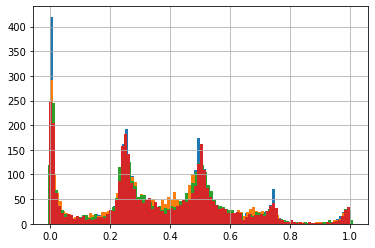

In [28]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()